In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
sns.set_style('darkgrid')

In [86]:
df = pd.read_csv('sample_trips.csv')

In [87]:
df.head(10)

,trip_nb,local_dtm,latitude,longitude
0,1,19MAY17:07:33:59,40.037952,-83.071342
1,1,19MAY17:07:34:01,40.038181,-83.071274
2,1,19MAY17:07:34:02,40.038349,-83.071304
3,1,19MAY17:07:34:03,40.038448,-83.071266
4,1,19MAY17:07:34:04,40.038551,-83.071236
5,1,19MAY17:07:34:06,40.038795,-83.071243
6,1,19MAY17:07:34:07,40.038895,-83.071236
7,1,19MAY17:07:34:08,40.039013,-83.071213
8,1,19MAY17:07:34:09,40.039116,-83.071205
9,1,19MAY17:07:34:10,40.039230,-83.071190


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9687 entries, 0 to 9686
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   trip_nb    9687 non-null   int64  
 1   local_dtm  9687 non-null   object 
 2   latitude   9687 non-null   float64
 3   longitude  9687 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 302.8+ KB


In [89]:
df = df.drop(df[df['latitude']==0].index)
df = df.drop(df[df['longitude']==0].index)

In [90]:
## Removing Lats-lons with sudden change in value during the same trip number
for ii in reversed(range(len(df))):
    if df['trip_nb'].iloc[ii] == df['trip_nb'].iloc[ii-1]:
        if ((df['latitude'].iloc[ii] / df['latitude'].iloc[ii-1]) > 1.05) | ((df['latitude'].iloc[ii] / df['latitude'].iloc[ii-1]) < 0.95):
            df.drop(index=ii-1,axis=0,inplace=True)
            ii = ii+1

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9679 entries, 0 to 9686
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   trip_nb    9679 non-null   int64  
 1   local_dtm  9679 non-null   object 
 2   latitude   9679 non-null   float64
 3   longitude  9679 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 378.1+ KB


In [92]:
df['trip_nb'].value_counts()

8     1658
3     1210
1     1109
11     997
5      984
12     828
6      676
2      632
9      552
15     240
16     178
7      163
14     133
4      127
10     102
13      90
Name: trip_nb, dtype: int64

In [93]:
def distance(lat1,lat2,lon1,lon2): # Distance in meters
    dist = 6373*1000*math.acos(math.sin(math.radians(lat1))*math.sin(math.radians(lat2)) +
                            math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.cos(math.radians(lon1 - lon2)))
    return dist

In [94]:
distance(40.037952,40.038181,-83.071342,-83.071274)

26.121790359398265

In [95]:
df['dist'] = np.nan # Distance in meters
df['time'] = np.nan # Time in seconds
df['speed'] = np.nan # Speed in m/s
df['datetime']=df['local_dtm'].apply(lambda date: '2020-01-02 '+date[-8:])
df['datetime'] = pd.to_datetime(df['datetime'])

In [96]:
df['dist'].iloc[0]=0
df['time'].iloc[0]=0
df['speed'].iloc[0]=0
for ii in range(1,len(df)):
    if (df['latitude'].iloc[ii-1] == df['latitude'].iloc[ii]) & (df['longitude'].iloc[ii-1] == df['longitude'].iloc[ii]):
        df['dist'].iloc[ii] = 0 # If the car has stopped
    elif df['trip_nb'].iloc[ii] != df['trip_nb'].iloc[ii]:
        df['dist'].iloc[ii] = 0 # When switching to a new trip number
        df['time'].iloc[ii] = 0
        df['speed'].iloc[ii] = 0
    else:
        df['dist'].iloc[ii] = distance(df['latitude'].iloc[ii-1],df['latitude'].iloc[ii],df['longitude'].iloc[ii-1],df['longitude'].iloc[ii])
        df['time'].iloc[ii] = int((df['datetime'].iloc[ii]-df['datetime'].iloc[ii-1]) / np.timedelta64(1,'s'))
        df['speed'].iloc[ii] = df['dist'].iloc[ii] / df['time'].iloc[ii]

df.drop('datetime',axis=1,inplace=True)

C:\Users\uranu\Anaconda3\envs\tf_env_gpu\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\uranu\Anaconda3\envs\tf_env_gpu\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


In [97]:
df = df.drop(df[df['time']==0].index)

In [99]:
df['accel'] = np.nan # Acceleration in m2/s
df['accel'].iloc[0]=0
for ii in range(1,len(df)):
    if df['trip_nb'].iloc[ii] != df['trip_nb'].iloc[ii]:
        df['accel'].iloc[ii] = 0 # When switching to a new trip number
    else:
        df['accel'].iloc[ii] = (df['speed'].iloc[ii] - df['speed'].iloc[ii-1]) / df['time'].iloc[ii]


In [100]:
df.head(10)

,trip_nb,local_dtm,latitude,longitude,dist,time,speed,accel
1,1,19MAY17:07:34:01,40.038181,-83.071274,26.121790,2.0,13.060895,0.000000
2,1,19MAY17:07:34:02,40.038349,-83.071304,18.860796,1.0,18.860796,5.799901
3,1,19MAY17:07:34:03,40.038448,-83.071266,11.477034,1.0,11.477034,-7.383761
4,1,19MAY17:07:34:04,40.038551,-83.071236,11.738086,1.0,11.738086,0.261052
5,1,19MAY17:07:34:06,40.038795,-83.071243,27.146567,2.0,13.573284,0.917599
6,1,19MAY17:07:34:07,40.038895,-83.071236,11.138479,1.0,11.138479,-2.434805
7,1,19MAY17:07:34:08,40.039013,-83.071213,13.270672,1.0,13.270672,2.132193
8,1,19MAY17:07:34:09,40.039116,-83.071205,11.477034,1.0,11.477034,-1.793638
9,1,19MAY17:07:34:10,40.039230,-83.071190,12.744444,1.0,12.744444,1.267410
10,1,19MAY17:07:34:12,40.039410,-83.071152,20.281220,2.0,10.140610,-1.301917


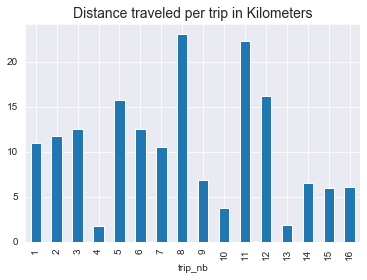

In [101]:
plt.figure()
plt.title('Distance traveled per trip in Kilometers', fontsize=14)
(df.groupby('trip_nb')['dist'].sum() / 1000 ).plot(kind='bar')

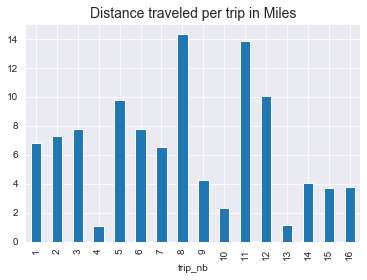

In [102]:
plt.figure()
plt.title('Distance traveled per trip in Miles', fontsize=14)
(df.groupby('trip_nb')['dist'].sum() / 1609.34 ).plot(kind='bar')

# Hard Accelerations and Hard Brakes

##### Hard Acceleration if accelaration is greater than mean+3*Std.Dev of positive accelerations
##### Hard Brake if accelaration is less than mean+3*Std.Dev of negative accelerations

In [106]:
thr_pos = df[df['accel']>0]['accel'].mean()+3*df[df['accel']>0]['accel'].std()
thr_neg = df[df['accel']<0]['accel'].mean()-3*df[df['accel']>0]['accel'].std()
thr_pos, thr_neg

(10.70509033236763, -10.7272137597666)

In [107]:
df['HardAccelerations'] = df['accel'].apply(lambda accel: 1 if accel > thr_pos else 0)
df['HardBrakes'] = df['accel'].apply(lambda accel: 1 if accel < thr_neg else 0)

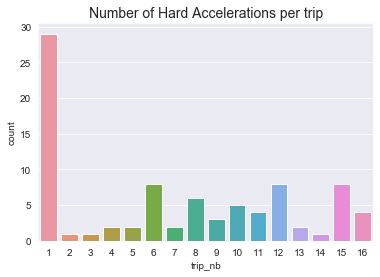

In [150]:
plt.figure()
plt.title('Number of Hard Accelerations per trip', fontsize=14)
sns.countplot(x='trip_nb', data=df[df['HardAccelerations']==1], order = df['trip_nb'].unique())

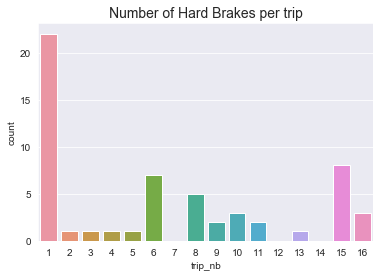

In [151]:
plt.figure()
plt.title('Number of Hard Brakes per trip', fontsize=14)
sns.countplot(x='trip_nb', data=df[df['HardBrakes']==1], order=df['trip_nb'].unique())

# Part 2 

In [128]:
df2 = pd.read_csv('simulated_summary_total.csv')
df2.head()

,Vehicle,Days,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,1,365,13114,152,56,0.005,SUV,0
1,2,365,18707,147,1,0.010,SUV,0
2,3,365,16659,151,127,0.019,Truck,0
3,4,365,13330,126,147,0.000,SUV,1
4,5,365,22533,10,11,0.001,Truck,0


In [182]:
df2['Loss'].value_counts()

0    25969
1     4031
Name: Loss, dtype: int64

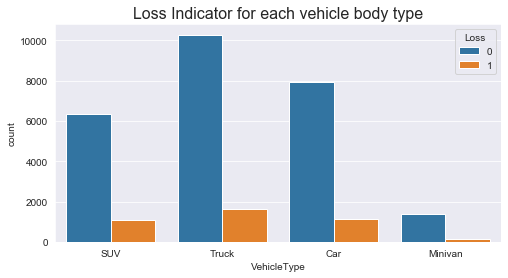

In [183]:
plt.figure(figsize=(8,4))
plt.title('Loss Indicator for each vehicle body type', fontsize=16)
sns.countplot(x='VehicleType', data=df2, hue='Loss')

## SUVs and Trucks have higher chance of incidents, but the difference is not significant

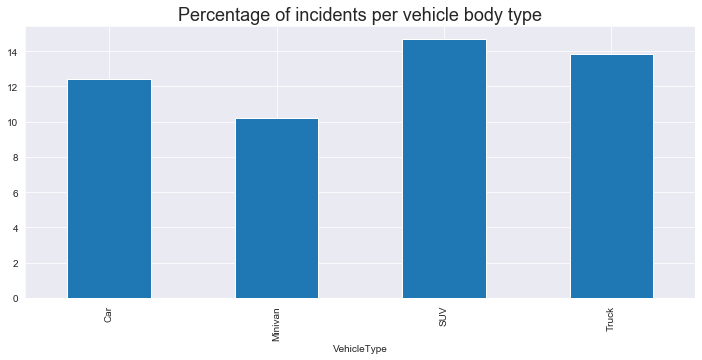

In [181]:
loss_1 = df2[df2['Loss']==1].groupby('VehicleType').count()['Loss']
loss_all = df2.groupby('VehicleType').count()['Loss']

plt.figure(figsize=(12,5))
plt.title('Percentage of incidents per vehicle body type', fontsize=18)
((loss_1 / loss_all)*100).plot(kind='bar')

In [130]:
df2['Days'].value_counts() # All the same input for Days column

365    30000
Name: Days, dtype: int64

In [162]:
df2.drop(['Vehicle','Days'], axis=1, inplace=True)

### Hard Acceleration has more correlation with loss than Hard Brakes

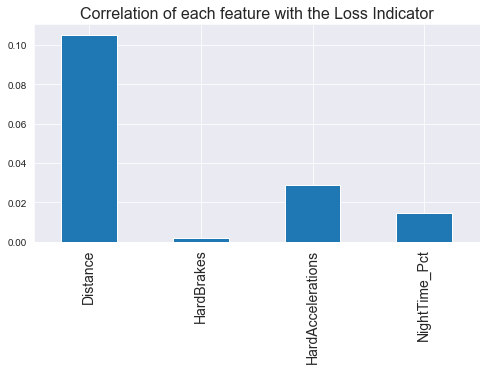

In [170]:
plt.figure(figsize=(8,4))
plt.title('Correlation of each feature with the Loss Indicator', fontsize=16)
plt.xticks(fontsize=14)
df2.corr()['Loss'][:-1].plot(kind='bar')

In [110]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.metrics import classification_report, confusion_matrix

### One-hot encoding of the categorical features (using dummy variables)

In [129]:
df_model = df2.copy()

In [132]:
dummies = pd.get_dummies(df_model['VehicleType'], drop_first=True)

In [133]:
df_model = pd.concat([df_model.drop('VehicleType',axis=1),dummies],axis=1)
df_model.head()

,Distance,HardBrakes,HardAccelerations,NightTime_Pct,Loss,Minivan,SUV,Truck
0,13114,152,56,0.005,0,0,1,0
1,18707,147,1,0.010,0,0,1,0
2,16659,151,127,0.019,0,0,0,1
3,13330,126,147,0.000,1,0,1,0
4,22533,10,11,0.001,0,0,0,1


In [192]:
df_model = df2.copy()

In [194]:
df_model['HardBrakes_ratio'] = df_model['HardBrakes']/df_model['Distance']
df_model['HardAccelerations_ratio'] = df_model['HardAccelerations']/df_model['Distance']

In [195]:
df_model.head()

,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss,HardBrakes_ratio,HardAccelerations_ratio
0,13114,152,56,0.005,SUV,0,0.011591,0.004270
1,18707,147,1,0.010,SUV,0,0.007858,0.000053
2,16659,151,127,0.019,Truck,0,0.009064,0.007624
3,13330,126,147,0.000,SUV,1,0.009452,0.011028
4,22533,10,11,0.001,Truck,0,0.000444,0.000488


## Spliting Train/Test Data

In [210]:
X = df_model[['Distance', 'HardBrakes_ratio','HardAccelerations_ratio','NightTime_Pct']].values
y = df_model['Loss'].values

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [234]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [235]:
X_train.shape

(22500, 4)

# Training a Logistic Regression Model

In [236]:
from sklearn.linear_model import LogisticRegression

In [237]:
logmodel = LogisticRegression()

logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [238]:
predictions_log = logmodel.predict(X_test)

In [239]:
print(classification_report(y_test, predictions_log))
print('\n')
print(confusion_matrix(y_test, predictions_log)) # Confusion Matrix ([[tn, fp], [fn, tp]])

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      6512
           1       0.00      0.00      0.00       988

    accuracy                           0.87      7500
   macro avg       0.43      0.50      0.46      7500
weighted avg       0.75      0.87      0.81      7500



[[6512    0]
 [ 988    0]]


C:\Users\uranu\Anaconda3\envs\tf_env_gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Trainig a Deep Learning Neural Network Model

In [240]:
model = Sequential()

model.add(Dense(4, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(4, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(2, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [241]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [242]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
         callbacks=[early_stop], epochs=200, batch_size=64)

Train on 22500 samples, validate on 7500 samples
Epoch 1/200
22500/22500 [==============================] - 3s 125us/sample - loss: 0.5322 - val_loss: 0.4005
Epoch 2/200
22500/22500 [==============================] - 1s 58us/sample - loss: 0.4319 - val_loss: 0.3936
Epoch 3/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.4230 - val_loss: 0.3925
Epoch 4/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.4150 - val_loss: 0.3895
Epoch 5/200
22500/22500 [==============================] - 2s 69us/sample - loss: 0.4097 - val_loss: 0.3879
Epoch 6/200
22500/22500 [==============================] - 1s 62us/sample - loss: 0.4067 - val_loss: 0.3868
Epoch 7/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.4028 - val_loss: 0.3867
Epoch 8/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.4028 - val_loss: 0.3862
Epoch 9/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.40

Epoch 76/200
22500/22500 [==============================] - 1s 65us/sample - loss: 0.3935 - val_loss: 0.3851
Epoch 77/200
22500/22500 [==============================] - 1s 60us/sample - loss: 0.3939 - val_loss: 0.3844
Epoch 78/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.3936 - val_loss: 0.3842
Epoch 79/200
22500/22500 [==============================] - 1s 63us/sample - loss: 0.3937 - val_loss: 0.3846
Epoch 80/200
22500/22500 [==============================] - 1s 62us/sample - loss: 0.3937 - val_loss: 0.3847
Epoch 81/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.3933 - val_loss: 0.3844
Epoch 82/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.3934 - val_loss: 0.3843
Epoch 83/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.3934 - val_loss: 0.3845
Epoch 84/200
22500/22500 [==============================] - 1s 60us/sample - loss: 0.3937 - val_loss: 0.3850
Epoch 85/200
22500/

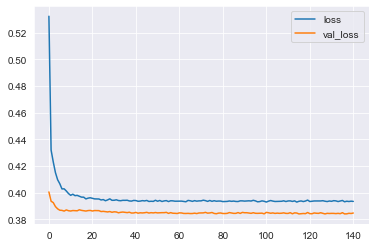

In [243]:
pd.DataFrame(model.history.history).plot()

In [231]:
predictions = model.predict_classes(X_test)

In [232]:
print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions)) # Confusion Matrix ([[tn, fp], [fn, tp]])

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      5204
           1       0.00      0.00      0.00       796

    accuracy                           0.87      6000
   macro avg       0.43      0.50      0.46      6000
weighted avg       0.75      0.87      0.81      6000



[[5204    0]
 [ 796    0]]


C:\Users\uranu\Anaconda3\envs\tf_env_gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
